# Differentiable Augmentation for Data-Efficient GAN Training
> Shengyu Zhao(IIIS, Tsinghua University and MIT), Zhijian Liu(MIT), Ji Lin(MIT), Jun-Yan Zhu(Adobe and CMU), Song Han(MIT)

- toc:true
- branch: master
- badges: false
- comments: false 
- author: 최서연
- categories: [GAN, 논문리뷰]

ref: https://proceedings.neurips.cc/paper/2020/file/55479c55ebd1efd3ff125f1337100388-Paper.pdf

ref: https://github.com/mit-han-lab/data-efficient-gans

> youtube: https://youtu.be/SsqcjS6SVM0

## Abstract

- The performance of generative adversarial networks (GANs) heavily deteriorates given a limited amount of training data. 
    - 제한된 양의 학습 데이터가 주어지면 성능 나빠짐
    - discriminator가 정확한 training set 기억하는 주된 이유
- To combat it, we propose Differentiable Augmentation (DiffAugment), a simple method that improves the data efficiency of GANs by imposing various types of differentiable augmentations on both real and fake samples. 
    - 실제/가짜 sample에 differentiable augmentations의 다양한 type 부과해서 GAN의 data 효율성을 증진하는 DiffAugment(Differentiable Augmentation) 제시
    - 일반화된 sample에서 differentiable augmentation 차별화된 확대 수용하면 training이 효율적으로 안정화하고 더 나은 convergence를 이끔
    - only 20% training data, we can match the top performance on CIFAR-10 and CIFAR-100
    - our method can generate high-fidelity images using only 100 images without pre-training, while being on par with existing transfer learning algorithms. 

##  Method

GANs(Generative Adversarial Networks)는 generator G와 discriminator D로 target dataset의 분포를 모델링하는 것이 목적

genorator G는 typically 가우시안 분포에서 나온 입력 latent 벡터 z에서 출력 G(z)에 mapping한다.

discriminator D는 실제 관측치 x에서 generated sample G(z)를 구별해내는 것을 배움

The standard GANs training algorithm alternately optimizes the discriminator’s loss $L_D$ and the generator’s loss $L_G$ given loss functions $f_D$ and $f_G$:
$$L_D = E_{x~p_{data}(x)}|f_D (-D(x))| + E_{x~p(x)}|f_D (D(G(z)))|, \dots(1)$$
$$L_G = E_{x~p(x)} |f_G (-D(G(z)))|, \dots(2)$$

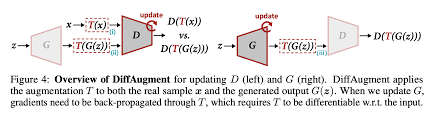

Figure 4: Overview of DiffAugment for updating D (left) and G (right)
- DiffAugment는 실제 smaple x와 generated 출력 G(z)에 augmentation T를 적용
- G를 업데이트하면 기울기는 T로 역전파되어야 하며 T는 입력으로 미분할 수 있어야 함

Here, different loss functions can be used, such as the non-saturating loss, where $f_D(x) = f_G(x) = log (1 + e^x)$, and the hinge loss, where $f_D(x) = max(0, 1 + x)$ and $f_G(x) = x$.

the discriminator tends to memorize the observations as the training progresses.
- discrminator는 training 한 관찰을 기억하는 경향이 있음

An overfitted discriminator penalizes any generated samples other than the exact training data points, provides uninformative gradients due to poor generalization, and usually leads to training instability.
- 과적합 discriminator는 정확한 training data point 외의 generated sample에 penalize하고, poor generation 따문에 정보 없는 gradient를 제공하지 않으며 training 불안정성을 이끈다.

**Challenge: Discriminator Overfitting**
- CIFAR-10 사용하여 BigGAN 성능 분석
- figure 1 미루어보아 데이터가 100% 주어져도 genarator과 discriminator 사이의 격차 계속 증가
    - discriminator가 단순하게 training image를 기억하고 있다는 뜻

## Revisiting Data Augmentation

Data augmentation is a commonly-used strategy to reduce overfitting in many recognition tasks.
- it has an irreplaceable role and can also be applied in conjunction with other regularization techniques: e.g., weight decay.

the discriminator suffers from a similar overfitting problem as the binary classifier.
- data augmentation is seldom used in the GAN literature compared to the explicit regularizations on the discriminator
-  In fact, a recent work [50] observes that directly applying data augmentation to GANs does not improve the baseline. 

ask the questions:
- what prevents us from simply applying data augmentation to GANs? 
- Why is augmenting GANs not as effective as augmenting classifiers?

**Augment reals only**

The most straightforward way of augmenting GANs would be directly applying augmentation T to the real observations x, which we call “Augment reals only”: GAN 확대 혹은 증가를 위한 간단한 방법, Augment reals only라 부르는 실제 관측치 x를 T에 직접 적용시키기
$$L_D = E_{x~p_{data}(x)}|f_D (-D(T(x))))| + E_{x~p(x)}|f_D(D(G((z))))|, \dots (3)$$

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQrxZ_1odR9kZuceLJYnEX3HRBwC5GY7R_H9Q&usqp=CAU)

Figure 5. Understanding why vanilla augmentation strategies fail: 
- (a) “Augment reals only” 는 확대augmentation와 동일한 데이터 왜곡 의미, 
- (b)“Augment D only” 는 augment된 T(x)와 T(G(z))를 완벽하게 분리하지만 G(z)(Augmentation없는 가짜 이미지)를 거의 인지하지 못함.

**“Augment reals only”**는 generative modeling의 원래 목적에서 벗어남.
- 모델이 x대신에 T(x)의 다른 data distribution에서 learning하고 있기 때문이다.
- 이는 실제 이미지의 분포가 크게 변화하여 어느 augmentation이든 적용하는 것으로부터 막기 때문.
    - This prevents us from applying any augmentation that significantly alters the distribution of the real images.
- 비록 강하게 특정 dataset에 의존하지만, 이 요구 사항을 만족하는 선택은 대부분 case에서 수평 flip이 될 수 있다.
    - The choices that meet this requirement, although strongly dependent on the specific dataset, can only be horizontal flips in most cases. 
- 임의의 수평 flip을 적용하는 것은 성능이 보통 상승하는 것을 알 수 있어 baseline 을 더 stronger하게 만들기 위해 모든 experiment에서 임의의 수평 플립 사용함
    - We find that applying random horizontal flips does increase the performance moderately, and we use it in all our experiments to make our baselines stronger.
- 모델은 augmentation으로 도입된 원치 않는 색과 기하학적 왜곡을 생성하는 방법을 학습하여 성능이 크게 저하됨.
    - As expected, the model learns to produce unwanted color and geometric distortion (e.g., unnatural color, cutout holes) as introduced by these augmentations, resulting in a significantly worse performance

**Augment D only**
- Augment reals only 은 실제 sample에 one-sided augmentation을 적용했던 것은 generated 분포가 manupulated 실제 분포와 일치한는 경우에만 convergence수렴이 achive될 수 있었다.
    - Previously, “Augment reals only” applies one-sided augmentation to the real samples, and hence the convergence can be achieved only if the generated distribution matches the manipulated real distribution.
- discriminator의 관점에서 D를 업데이트할 때 진짜와 가짜 sample 모두 augment 하는 것이 temp할 수 있음.
    - From the discriminator’s perspective, it may be tempting to augment both real and fake samples when we update D:
$$L_D = E_{x~p_{data}(z)}|f_D(-D(T(x)))| + E_{x~p(x)}|f_D(D(T(G(z))))|, \dots (5)$$
$$L_G = E_{x~p(x)}|f_G (-D(G(z)))|, \dots (6)$$

- 실제 sample x와 가짜 sample G(z)가 같은 함수 T에 적용됨.
- generator가 x의 분포를 성공적을 모델링한다면, G(z)와 x  뿐만 아니라 T(G(z)와 T(x)도 discriminator에 의해 판별될 수 없어야 한다.
    - If the generator successfully models the distribution of x, T(G(z)) and T(x) should be indistinguishable to the discriminator as well as G(z) and x.
- 하지만 이 strategy는 worse result를 이끔(Table 1에서 “Augment D only” 부분)
- Figure 5 (b)“Augment D only” 에서는 Translatopnn이 적용된 training dynamics plot임
    -  Figure 5 b plots the training dynamics of “Augment D only” with Translation applied. 
- 비록 D는 90% 이상의 정확도로 완벽하게 augmenteg image들인 T(G(z))와 T(x)를 분류해내지만, 10% 이하의 정확도로 augmentation 없이 generated image인 G(z)를 인식하는 데 실패함
    - Although D classifies the augmented images (both T(G(z)) and T(x)) perfectly with an accuracy of above 90%, it fails to recognize G(z), the generated images without augmentation, with an accuracy of lower than 10%.
- 결과적으로, generator는 G(z)에 의해 discriminator를 완전히 fool하고 discriminator로부터 유용한 정보를 얻릉 수 없다.
    -  As a result, the generator completely fools the discriminator by G(z) and cannot obtain useful information from the discriminator.
- generator G와 discriminator D 사이의 delicate한 균형을 깨는 시도가 실패하기 쉽다는 것을 나타냄.

##   Differentiable Augmentation for GANs

Augment reals only의 실패는 실제와 가짜 sample을 augment하도록 동기부여 하지만, Augment D only의 실패는 generator가 augmented sample을 놔둬서는 안 된다고 경고한다.
- The failure of “Augment reals only” motivates us to augment both real and fake samples, while the failure of “Augment D only” warns us that the generator should not neglect the augmented samples.
- augmented sample 을 통해 G로 gradient를 전파하기 위해 augmentation T 는 구별될 수 있어야함.
    - 이게 바로 Differentiable Augmentation (DiffAugment)
$$L_D = E_{x~p_{data}}(x)[f_D (-D(T(x)))] + E_{x~p(x)}[f_D(D(T(G(z))))], \dots (7)$$
$$L_g = E_{z~p(z)}[f_G(-D(T(G(z))))], \dots (8)$$

- T는 동일한 임의의 함수, 하지만 세 위치에 거쳐 꼭 동일한 임의의 seed를 가질 필요는 없음
    -  Note that T is required to be the same (random) function but not necessarily the same random seed across the three places illustrated in Figure 4.
-  As shown in Table 1, BigGAN can be improved using the simple Translation policy and further boosted using a composition of Cutout and Translation; it is also robust to the strongest policy when Color is used in combined.
- Figue 6에서 stronger한 DiffAugment policy가 일반적으로 더 낮은 training 정확도의 cost애서 더 높은 discriminator의 검증 정확도를 유지하고, overfitting을 완화하며, 결과적으로 더 나은 수렴convergence를 성취achieve했다고 분석한다.
    - Figure 6 analyzes that stronger DiffAugment policies generally maintain a higher discriminator’s validation accuracy at the cost of a lower training accuracy, alleviate the overfitting problem, and eventually achieve better convergence.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSyl7x7gcXynJl30VgC2_x7cIS-EXMZ-dfioZCGfvsY1sxVVja47qBjZUFCdHWhgY2oNYo&usqp=CAU)

Figure 6: Analysis of different types of DiffAugment on CIFAR-10 with 100% training data. 
- stronger한 DiffAugment가 극적으로 discriminator의 training 정확도(중간)와 validation 정확도(오른쪽) 차이를 감소할 수 있어 더 나은 수렴convergence에(왼쪽) 이르게 할 수 있다.
    - A stronger DiffAugment can dramatically reduce the gap between the discriminator’s training accuracy (middle) and validation accuracy (right), leading to a better convergence (left)

## Experiments

### ImageNet

- We follow the top-performing model BigGAN [2] on ImageNet dataset at 128×128 resolution. 
- Additionally, we augment real images with random horizontal flips, yielding the best reimplementation of BigGAN to our knowledge (FID: ours 7.6 vs. 8.7 in the original paper [2]). 
- We use the simple Translation DiffAugment for all the data percentage settings. 

###  FFHQ and LSUN-Cat

- We further experiment with StyleGAN2 [18] on the FFHQ portrait dataset [17] and the LSUN-Cat dataset [46] at 256×256 resolution.
- We investigate different limited data settings, with 1k, 5k, 10k, and 30k training images available.
- We apply the strongest Color + Translation + Cutout DiffAugment to all the StyleGAN2 baselines without any hyperparameter changes. 
- The real images are also augmented with random horizontal flips as commonly applied in StyleGAN2 [18].
- 성능이 모든 데이터 백분율 설정에서 고려할만했음!
- 게다가 DiffAugment에 사용되는 고정 정책으로 성능이 adoptive augmentation strategy에 기반한 동시작업인 ADA와 동등함.
    - Moreover, with the fixed policies used in DiffAugment, our performance is on par with ADA [16], a concurrent work based on the adaptive augmentation strategy.

### CIFAR-10 and CIFAR-100

- experiment on the class-conditional BigGAN [2] and CR-BigGAN [50] and unconditional StyleGAN2 [18] models.
- For a fair comparison, augment real images with random horizontal flips for all the baselines. 

For DiffAugment, we adopt **Translation + Cutout** for the BigGAN models, **Color + Cutout** for StyleGAN2 with 100% data, and **Color + Translation + Cutout** for StyleGAN2 with 10% or 20% data.
-  Table 4로 미루어 보아 our method improves all the baselines independently of the baseline architectures, regularizations, and loss functions (hinge loss in BigGAN and non-saturating loss in StyleGAN2) without any hyperparameter changes.
    - The improvements are considerable especially when limited data is available. 

### Low-Shot Generation

image data가 제대로 수집이 되지 않았을때.
- fine-tunre을 통해 사전 훈련된 모델을 적용 시키기도 하고
    -  Wang et al. [45] use fine-tuning to transfer the knowledge of models pre-trained on external large-scale datasets.
- 모델의 일부만을 fine-tune하기도 함
    - Several works propose to fine-tune only part of the model [30,31,44]. 

논문에서 제안하는 것은 image data가 제대로 수집되지 않았을 때 외부 데이터셋이나 모델을 사용하지 않고 결쟁력있는 결과를 제공할 수 있을 뿐만 아니라 기존 전송 학습 방법과 직교한다는 것을 보여준다.
- Below, we show that our method not only produces competitive results without using external datasets or models but also is orthogonal to the existing transfer learning methods. 

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRFlqOukMAm5H9aJxZJ3M0DRN-kST79NJeffw&usqp=CAU)

Figure 7: Style space interpolation of our method for low-shot generation without pre-training. 
- The smooth interpolation results suggest little overfitting of our method even given small datasets.

For DiffAugment, we adopt Color + Translation + Cutout for StyleGAN2, Color + Cutout for both the vanilla fine-tuning algorithm TransferGAN [45] and FreezeD [30] that freezes the first several layers of the discriminator. 

Without any pre-training, we still achieve results on par with the existing transfer learning algorithms that require tens of thousands of images, with an exception on the 100-shot Obama dataset where pre-training with human faces clearly leads to better generalization. 

tiny dataset에서는 과적합의 문제가 있을 수 있지만 figure7은 style space의 선형 보간법을 통한 방법의 과적합이 적다는 것을 보여줌. 
- While there might be a concern that the generator is likely to overfit the tiny datasets (i.e., generating identical training images), Figure 7 suggests little overfitting of our method via linear interpolation in the style space [17]; please refer to the supplementary material for the nearest neighbor tests.

### Analysis

smaller model 이나 stronger regularization이 비슷하게 과접합을 줄일 수 있는지.또 DiffAugment 가 여전히 도움이 되는지 보기
- Below, we investigate whether smaller model or stronger regularization would similarly reduce overfitting and whether DiffAugment still helps. 

![](https://d3i71xaburhd42.cloudfront.net/dac89790fb29d5ddac521927f2fdbabc6d6cf3ab/12-Figure10-1.png)

Figure 8: Analysis of smaller models or stronger regularization on CIFAR-10 with 10% training data.
- (a) Smaller models reduce overfitting for the BigGAN baseline, while our method dominates its performance at all model capacities. 작은 모델은 BigGAN 기준선에 대한 과적합을 줄이지만 모든 model capacities에서 성능이 지배적이다.
- (b) Over a wide sweep of the R1 regularization γ for the baseline StyleGAN2, its best FID (26.87) is still much worse than ours (14.50). 기준선 StyleGAN2에 대해 R1 정규화의 wide sweep에 걸쳐, best FID는 논문에서 제시한 것보다 여전히 별로다.

**Model Size Matters**
- G,D의 채널 수를 점진적으로 절반으로 즐임으로서 model capacity 줄임
    - We reduce the model capacity of BigGAN by progressively halving the number of channels for both G and D.
- As plotted in Figure 8a, the baseline heavily overfits on CIFAR-10 with 10% training data when using the full model and achieves a minimum FID of 29.02 at 1/4 channels.
- However, it is surpassed by our method over all model capacities. 
- 4분의 1 채널로 논문의 모델은 21.57의 훨씬 더 나은 FID를 성취했지만, 그 차이는 모델이 커지게 될 수록 단조롭게 증가한다.
    - With 1/4 channels, our model achieves a significantly better FID of 21.57, while the gap is monotonically increasing as the model becomes larger.

**Stronger Regularization Matters**
- StyleGAN2는 training을 안정화하기 위해 R1 정규화를 선택하고, 강도를 10에서 10의 4제곱까지 증가시킨다.
    - As StyleGAN2 adopts the R1 regularization [27] to stabilize training, we increase its strength from γ = 0.1 to up to 104 and plot the FID curves in Figure 8b. 
- While we initially find that γ = 0.1 works best under the 100% data setting, the choice of γ = 103 boosts its performance from 34.05 to 26.87 under the 10% data setting. 
- When γ = 104 , within 750k iterations, we only observe a minimum FID of 29.14 at 440k iteration and the performance deteriorates after that. 
- Figure 8 (b)로 미루어보아 논문에서 제시한 DiffAugment가 정규화하는 것에 비해 효과적이라는 것을 알 수 있음
    - However, its best FID is still 1.8× worse than ours (with the default γ = 0.1). This shows that DiffAugment is more effective compared to explicitly regularizing the discriminator.

![](https://img-blog.csdnimg.cn/2596d75bcb594621a8fd45f36e8f0996.JPG?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl8zNzk1ODI3Mg==,size_16,color_FFFFFF,t_70)

Figure 9: Various types of DiffAugment consistently outperform the baseline. We report StyleGAN2’s FID on CIFAR-10 with 10% training data.

**Choice of DiffAugment Matters**

We investigate additional choices of DiffAugment in Figure 9, including random 90◦ rotations ({−90◦ , 0 ◦ , 90◦} each with 1/3 probability), Gaussian noise (with a standard deviation of 0.1), and general geometry transformations that involve bilinear interpolation, such as bilinear translation (within [−0.25, 0.25]), bilinear scaling (within [0.75, 1.25]), bilinear rotation (within [−30◦ , 30◦]), and bilinear shearing (within [−0.25, 0.25]). While all these policies consistently outperform the baseline, **we find that the Color + Translation + Cutout DiffAugment is especially effective**. The simplicity also makes it easier to deploy.

##  Conclusion

- present DiffAugment for data-efficient GAN training. 
- DiffAugment reveals valuable observations that augmenting both real and fake samples effectively prevents the discriminator from over-fitting, and that the augmentation must be differentiable to enable both generator and discriminator training. 

----------------

In [7]:
import tensorflow as tf


def DiffAugment(x, policy='', channels_first=False):
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    return x


def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + magnitude
    return x


def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x


def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

In [8]:
import torch
import torch.nn.functional as F


def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

In [ ]:
#from DiffAugment_pytorch import DiffAugment
from DiffAugment_tf import DiffAugment
policy = 'color,translation,cutout' # If your dataset is as small as ours (e.g.,
# hundreds of images), we recommend using the strongest Color + Translation + Cutout.
# For large datasets, try using a subset of transformations in ['color', 'translation', 'cutout'].
# Welcome to discover more DiffAugment transformations!

...
# Training loop: update D
reals = sample_real_images() # a batch of real images
z = sample_latent_vectors()
fakes = Generator(z) # a batch of fake images
real_scores = Discriminator(DiffAugment(reals, policy=policy))
fake_scores = Discriminator(DiffAugment(fakes, policy=policy))
# Calculating D's loss based on real_scores and fake_scores...
...

...
# Training loop: update G
z = sample_latent_vectors()
fakes = Generator(z) # a batch of fake images
fake_scores = Discriminator(DiffAugment(fakes, policy=policy))
# Calculating G's loss based on fake_scores...
...